In [50]:
import cv2
import sys
import os
import numpy as np
from scipy.stats import circmean, circstd
from matplotlib import pyplot as plt
from numpy import uint8


BLACK_THRESHOLD_VALUE = 76
WHITE_THRESHOLD_VALUE_MIN = 140
WHITE_THRESHOLD_SATURATION_MAX = 30

COLORFUL_PIXELS_REQUIRED = 1000

HUE_MARGIN = 10
SATURATION_MARGIN_MIN = 50
VALUE_MARGIN_MIN = 50

HUE_MAX_THRESHOLD = 179

HUE_STD_MAX = 10
SATURATION_STD_MAX = 45
VALUE_STD_MAX = 45


def readImageAsRGB(filename):
    BGR_image = cv2.imread(filename)
    RGB_image = cv2.cvtColor(BGR_image, cv2.COLOR_BGR2RGB)
    return RGB_image


def readImageAsHSV(filename):
    BGR_image = cv2.imread(filename)
    HSV_image = cv2.cvtColor(BGR_image, cv2.COLOR_BGR2HSV)
    return HSV_image


def getParametersFromImage(HSV_image):
    image_size = np.shape(HSV_image)[0]
    return image_size


def getMeanHSV(HSV_list):
    hue_list = []
    saturation_sum = 0
    value_sum = 0
    for hsv in HSV_list:
        hue_list.append(hsv[0])
        saturation_sum += hsv[1]
        value_sum += hsv[2]
    hue_mean = circmean(hue_list, high=HUE_MAX_THRESHOLD+1)
    saturation_mean = saturation_sum / len(HSV_list)
    value_mean = value_sum / len(HSV_list)
    return (hue_mean, saturation_mean, value_mean)


def getStdHSV(HSV_list):
    hue_list = []
    saturation_list = []
    value_list = []
    for hsv in HSV_list:
        hue_list.append(hsv[0])
        saturation_list.append(hsv[1])
        value_list.append(hsv[2])
    hue_std = circstd(hue_list, high=HUE_MAX_THRESHOLD+1)
    saturation_std = np.std(saturation_list)
    value_std = np.std(value_list)
    return (hue_std, saturation_std, value_std)


def findMainColor(HSV_image):
    image_size = getParametersFromImage(HSV_image)
    middle_px = image_size // 2
    counter = 0
    radius = 0
    hsv_list = []
    # collect colorful(non-black and non-white) pixels starting from center
    # procedure iterates through wider and wider squares until a certain amount is collected
    while (counter < COLORFUL_PIXELS_REQUIRED):
        for i in range(middle_px - radius, middle_px + radius + 1):
            for j in range(middle_px - radius, middle_px + radius + 1):
                if isEdge(i, j, middle_px, radius) and isColorful(HSV_image[i][j]):
                    counter += 1
                    hsv_list.append(HSV_image[i][j])
        radius += 1
    # inside_mask = np.zeros((np.shape(HSV_image)[0], np.shape(HSV_image)[1]))
    # inside_mask[middle_px][middle_px] = 1
    # inside_mask = np.array(inside_mask, dtype=uint8)
    # while (counter < COLORFUL_PIXELS_REQUIRED):
    #     border_mask = getBorderMask(inside_mask, 2)
    #     border_hsv_list = getHSVimageValuesFromMask(HSV_image,border_mask)
    #     for hsv in border_hsv_list:
    #         if isColorful(hsv):
    #             counter += 1
    #             hsv_list.append(hsv)
    #     inside_mask += border_mask

    return getMeanHSV(hsv_list)


def isEdge(x, y, middle, distance):
    return x == middle - distance or y == middle - distance or x == middle + distance or y == middle + distance


def isColorful(HSV_value):
    return not isBlack(HSV_value) and not isWhite(HSV_value)


def isBlack(HSV_value):
    return HSV_value[2] < BLACK_THRESHOLD_VALUE


def isWhite(HSV_value):
    return HSV_value[2] > WHITE_THRESHOLD_VALUE_MIN and HSV_value[1] < WHITE_THRESHOLD_SATURATION_MAX


def getHSVimageValuesFromMask(HSV_image, BIN_mask):
    HSV_list = []
    for i in range(np.shape(HSV_image)[0]):
        for j in range(np.shape(HSV_image)[1]):
            if BIN_mask[i][j]:
                HSV_list.append(HSV_image[i][j])
    return HSV_list


def applyMask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)


def getInsideMask(HSV_image, HSV_mean):
    """
    Funkcja zwracająca maskę obejmującą środek znaku bez obramówki
    """
    lower_hue = HSV_mean[0] - HUE_MARGIN
    if lower_hue < 0:
        lower_hue += HUE_MAX_THRESHOLD
    if lower_hue > HUE_MAX_THRESHOLD:
        lower_hue -= HUE_MAX_THRESHOLD

    upper_hue = HSV_mean[0] + HUE_MARGIN
    if upper_hue < 0:
        upper_hue += HUE_MAX_THRESHOLD
    if upper_hue > HUE_MAX_THRESHOLD:
        upper_hue -= HUE_MAX_THRESHOLD

    lowerBound = (
        lower_hue, HSV_mean[1] - SATURATION_MARGIN_MIN, HSV_mean[2] - VALUE_MARGIN_MIN)
    upperBound = (upper_hue, 255, 255)

    if lowerBound[0] > upperBound[0]:
        mask1 = cv2.inRange(HSV_image, lowerb=(
            0, lowerBound[1], lowerBound[2]), upperb=upperBound)
        mask2 = cv2.inRange(HSV_image, lowerb=lowerBound, upperb=(
            HUE_MAX_THRESHOLD, upperBound[1], upperBound[2]))
        mask = mask1 | mask2
    else:
        mask = cv2.inRange(HSV_image, lowerb=lowerBound, upperb=upperBound)

    temp = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = temp[-2]
    cv2.drawContours(mask, contours, contourIdx=-1,
                     color=(255, 255, 255), thickness=-1)

    return mask


def getBorderMask(inside_mask, contour_width):
    """
    Funkcja zwracająca maskę zawierającą obramówkę znaku
    """
    mask_contour = np.zeros(
        (np.shape(inside_mask)[0], np.shape(inside_mask)[1]))
    contours, hierarchy = cv2.findContours(
        inside_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask_contour, contours, -1,
                     (255, 255, 255), contour_width*2)
    mask_contour = np.array(mask_contour, dtype=uint8)
    return mask_contour - cv2.bitwise_and(mask_contour, inside_mask)


def getFinalMask(HSV_image, inside_mask):
    """
    Funkcja zwracająca maskę zawierającą wnętrze znaku wraz z obramówką
    """
    contour_px_iterator = 1
    hue_std = 0
    saturation_std = 0
    value_std = 0
    mask = inside_mask
    while (hue_std < HUE_STD_MAX and saturation_std < SATURATION_STD_MAX and value_std < VALUE_STD_MAX):
        mask_border = getBorderMask(mask, contour_px_iterator)
        mask_border_hsv_list = getHSVimageValuesFromMask(
            HSV_image, mask_border)
        hue_std = getStdHSV(mask_border_hsv_list)[0]
        saturation_std = getStdHSV(mask_border_hsv_list)[1]
        value_std = getStdHSV(mask_border_hsv_list)[2]
        if (hue_std < HUE_STD_MAX and saturation_std < SATURATION_STD_MAX and value_std < VALUE_STD_MAX):
            mask += mask_border
    return mask


def getSignWithoutBordersFromImage(filename):
    """
    Funkcja zwracająca środek znaku bez obramówki z obrazu
    """
    HSV_image = readImageAsHSV(filename)
    HSV_mean = findMainColor(HSV_image)
    mask = getInsideMask(HSV_image, HSV_mean)
    croppedSign = applyMask(readImageAsRGB(filename), mask)
    return croppedSign


def getSignFromImage(filename):
    """
    Funkcja zwracająca znak wycięty z obrazu
    """
    HSV_image = readImageAsHSV(filename)
    HSV_mean = findMainColor(HSV_image)
    inside_mask = getInsideMask(HSV_image, HSV_mean)
    mask_with_border = getFinalMask(HSV_image, inside_mask)
    return applyMask(readImageAsRGB(filename), mask_with_border)


# plt.imshow(getSignFromImage("./znaki/A-2.png"))
# plt.savefig("test.jpg")


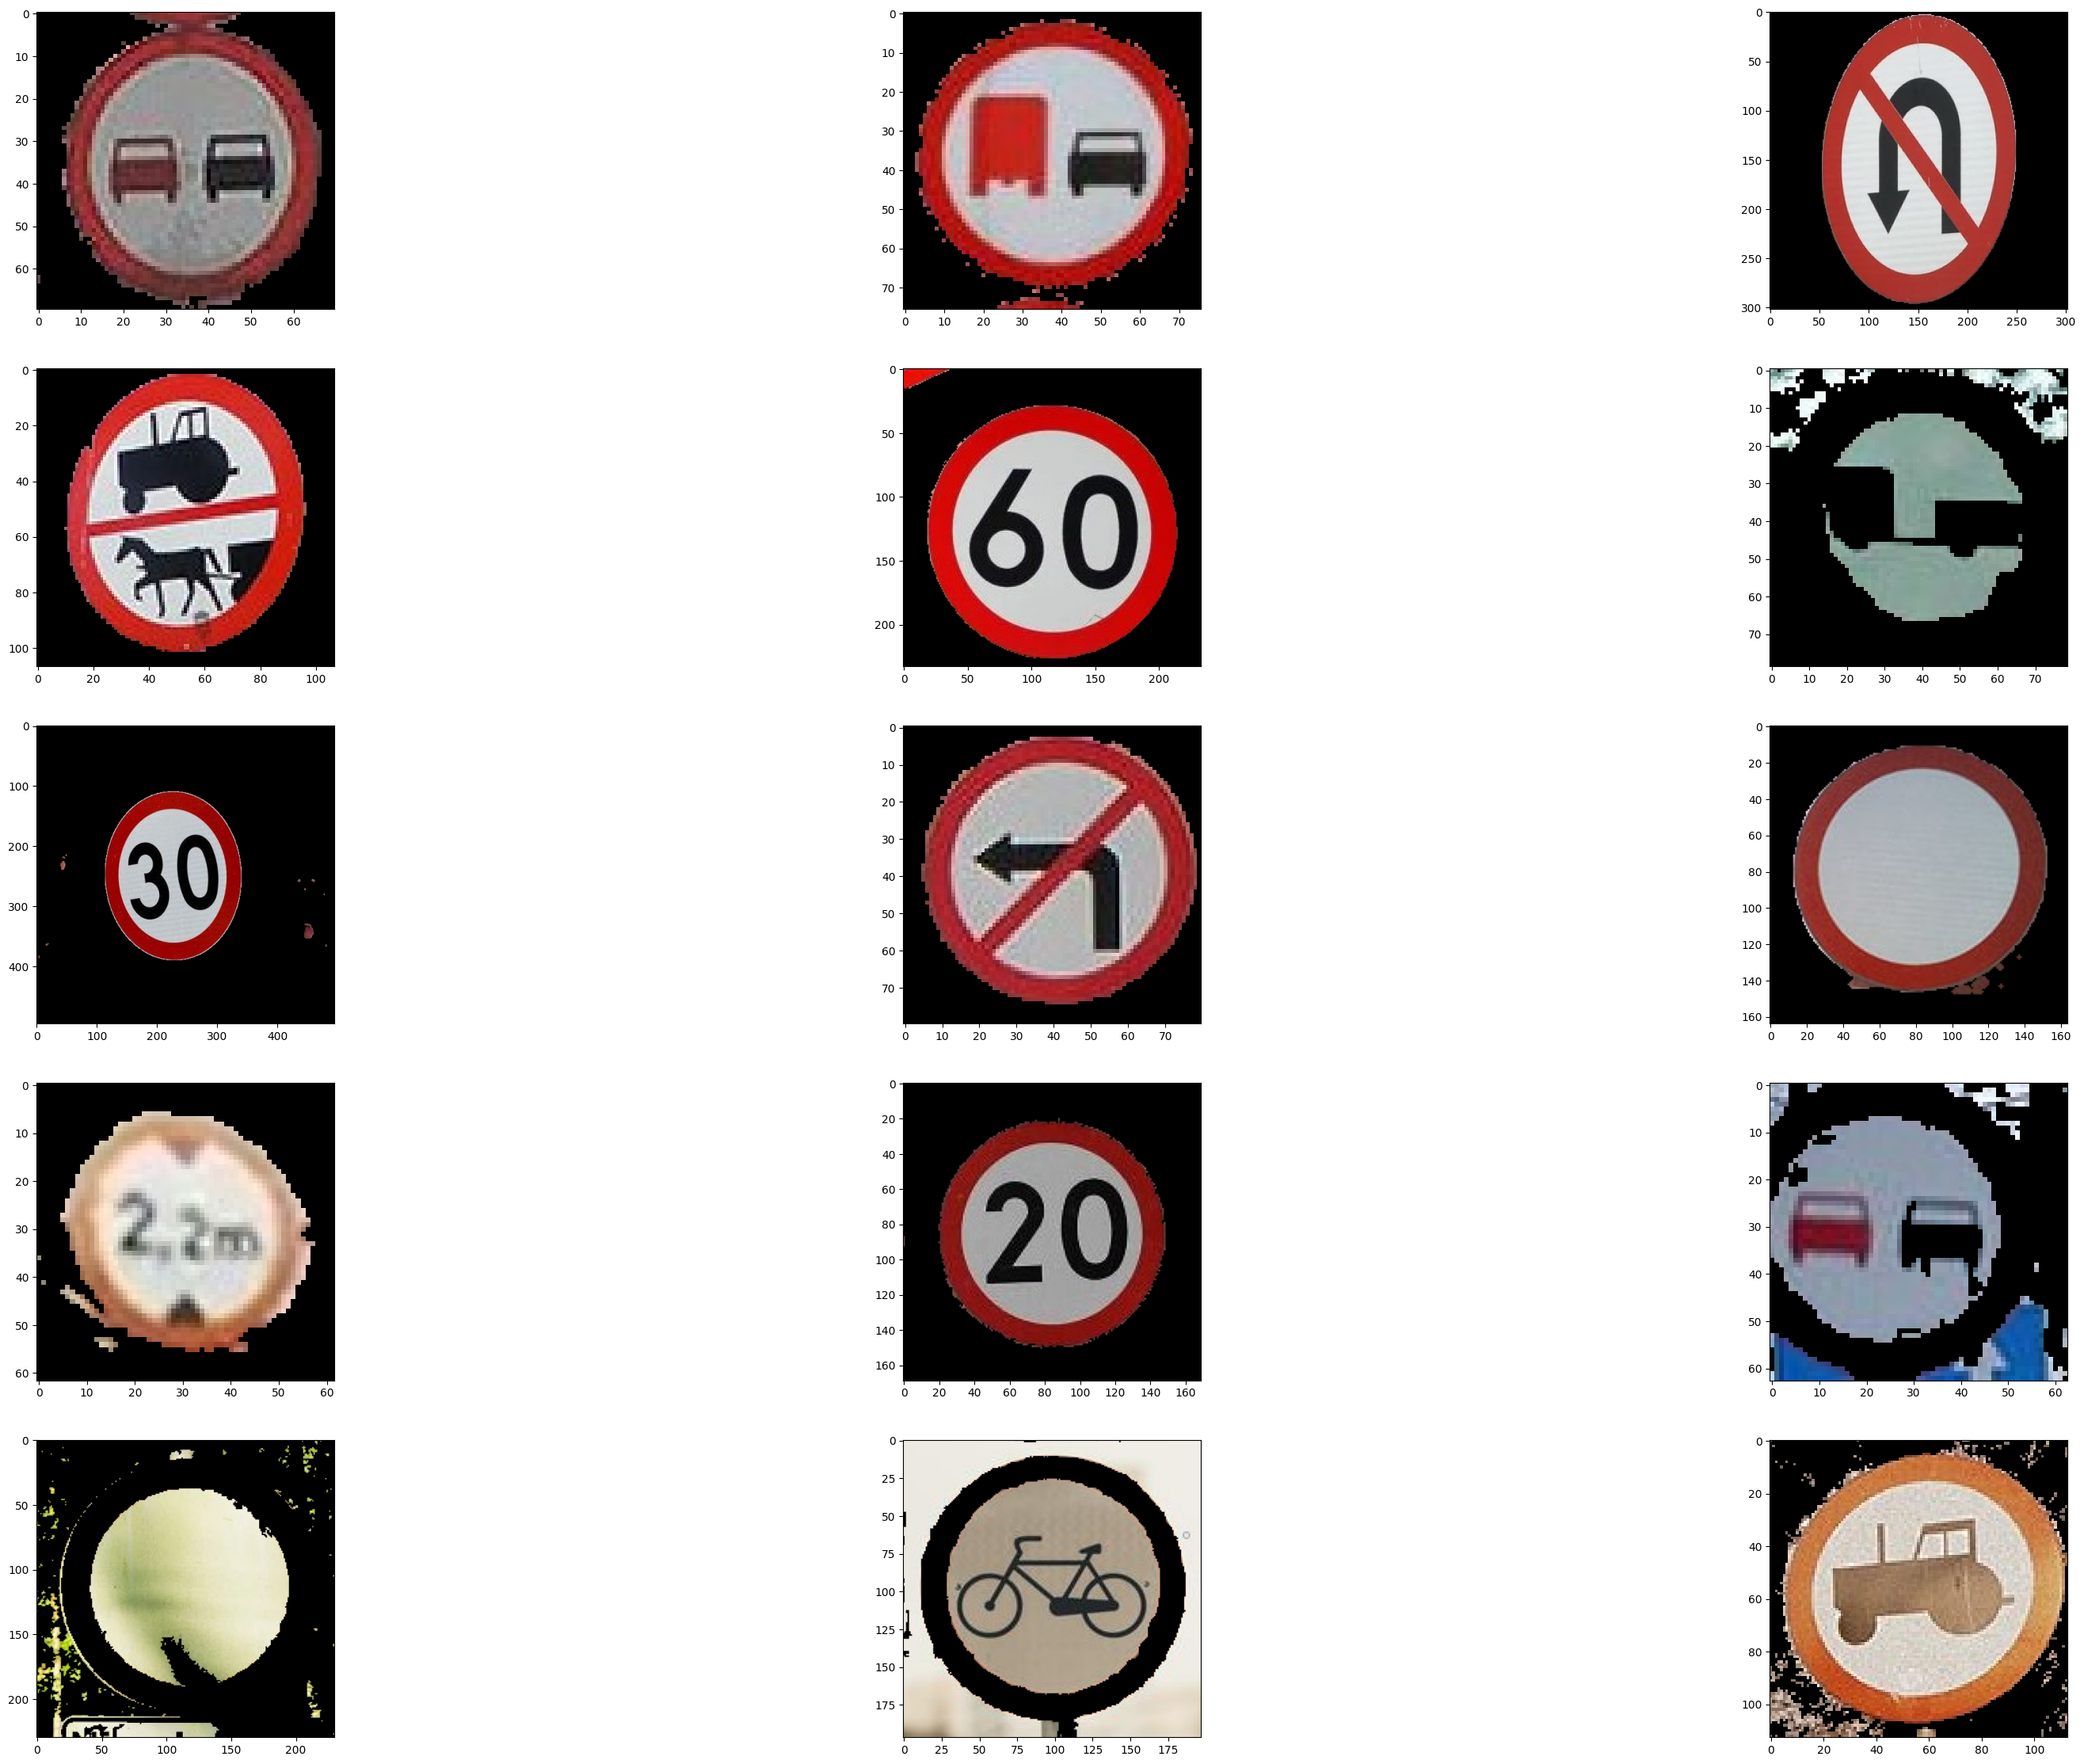

In [51]:
import glob 

def printSigns(image_list, is_grey):
    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(40)
    
    col_number = 3
    row_number = 7
    num = 1
    
    for img in image_list:
        plt.subplot(row_number,col_number,num)
        if is_grey:
            plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
        else:
            plt.imshow(img)
        num += 1

def showAllMasks():
    extensions = ("*.png", "*.jpg", "*.jpeg",)
    glob_list = []
    for extension in extensions:
        glob_list.extend(glob.glob("znaki/"+extension))

    mask_list = []

    for filename in glob_list:

        hue_mean, saturation_mean, value_mean = findMainColor(
            readImageAsHSV(filename))
        HSV_mean = (hue_mean, saturation_mean, value_mean)
        mask = getInsideMask(readImageAsHSV(filename), HSV_mean)
        mask_list.append(mask)

    printSigns(mask_list, True)


def showSingleMask(filename):
    hue_mean, saturation_mean, value_mean = findMainColor(
        readImageAsHSV(filename))
    HSV_mean = (hue_mean, saturation_mean, value_mean)
    mask = getInsideMask(readImageAsHSV(filename), HSV_mean)
    plt.imshow(mask, cmap='gray')


def showCroppedImages():
    extensions = ("*.png", "*.jpg", "*.jpeg",)
    glob_list = []
    for extension in extensions:
        glob_list.extend(glob.glob("znaki/"+extension))

    image_list = []

    for filename in glob_list:

        hue_mean, saturation_mean, value_mean = findMainColor(
            readImageAsHSV(filename))
        HSV_mean = (hue_mean, saturation_mean, value_mean)
        mask = getInsideMask(readImageAsHSV(filename), HSV_mean)
        image_list.append(applyMask(readImageAsRGB(filename), mask))
        # image_list.append(mask)

    printSigns(image_list, False)
    
def showFinalCroppedImages():
    extensions = ("*.png", "*.jpg", "*.jpeg",)
    glob_list = []
    for extension in extensions:
        glob_list.extend(glob.glob("znaki_zakazu/"+extension))
        # glob_list.extend(glob.glob("znaki_pierwsze/"+extension))

    image_list = []

    for filename in glob_list:

        HSV_mean = findMainColor(readImageAsHSV(filename))
        mask = getFinalMask(readImageAsHSV(filename), getInsideMask(readImageAsHSV(filename),HSV_mean))
        image_list.append(applyMask(readImageAsRGB(filename), mask))
        # image_list.append(mask)

    printSigns(image_list, False)
    
def showFinalCroppedImage(filename):
    HSV_mean = findMainColor(readImageAsHSV(filename))
    mask = getFinalMask(readImageAsHSV(filename), getInsideMask(readImageAsHSV(filename),HSV_mean))
    plt.imshow(applyMask(readImageAsRGB(filename), mask))
    
showFinalCroppedImages()
# showFinalCroppedImage("./znaki_zakazu/B-9_1.jpg")